<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Data Analysis</center></h1>
<h2><center>Seminar: Decision trees</center></h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# First of all..
Let's finish previous seminar super fast!

# Now, Decision Trees!

## Imputiry functions

* Lets recall main imputiry functions for classification

In [2]:
np.random.randint(1,25)

14

* Considering wine dataset from the intoductory seminar\assignment implement
    * impurity function (pick whichever you like)
    * gain calculation

In [3]:
def impurity_measure(p):
    '''
    function outputs a value of impurity function given an array with classes probabilities
    
    p: numpy array with classes probabilities
    '''
    
    impurity = 1 - p.max()
    
    return impurity

def wine_demo():
    # Data
    df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

    # Drawing
    fig, ax = plt.subplots(1, 2)

    fig.set_figheight(5)

    # Change to classification
    df_wine.loc[:, 'quality_cat'] = (df_wine.loc[:, 'quality'] > 5).astype(int) 
    idx = df_wine.loc[:, 'quality_cat'] == 1
    df_wine.loc[idx, 'alcohol'].hist(label='good quality', bins=20, alpha = 0.4, ax=ax[0])
    df_wine.loc[~idx, 'alcohol'].hist(label='bad quality', bins=20, alpha = 0.4, ax=ax[0])
    ax[0].set_xlabel('alcohol')
    
    # 
    p = np.array([df_wine.quality_cat.mean(), 1-df_wine.quality_cat.mean()])
    n = df_wine.shape[0] * 1.0

    init_impurity = impurity_measure(p)
    
    # Raw threshold search
    t_range = np.linspace(df_wine.alcohol.min(), df_wine.alcohol.max(), 100)

    # G is a list with Gains for each threshold
    G = []

    for t in t_range:
        idx = df_wine.alcohol < t
        n1 = idx.sum()
        n2 = (~idx).sum()
        p1 = np.array([df_wine.loc[idx, 'quality_cat'].mean(), 1-df_wine.loc[idx, 'quality_cat'].mean()])
        p2 = np.array([df_wine.loc[~idx, 'quality_cat'].mean(), 1-df_wine.loc[~idx, 'quality_cat'].mean()])
        
        current_gain = init_impurity - ((n1/n) * impurity_measure(p1) + (n2/n) * impurity_measure(p2))
        G.append(current_gain)
        

    ax[1].plot(t_range, G)
    ax[1].set_xlabel('alcohol')
    ax[1].set_ylabel('Gain')

    mG = np.nanmax(G)
    mt = t_range[np.nanargmax(G)]

    ax[0].vlines(mt, 0, 150, label='best threshold (%.2f)' % mt)
    ax[1].vlines(mt, 0, mG, label='best threshold\n(gain = %.4f)' % mG)
    
    ax[0].legend()
    ax[1].legend()

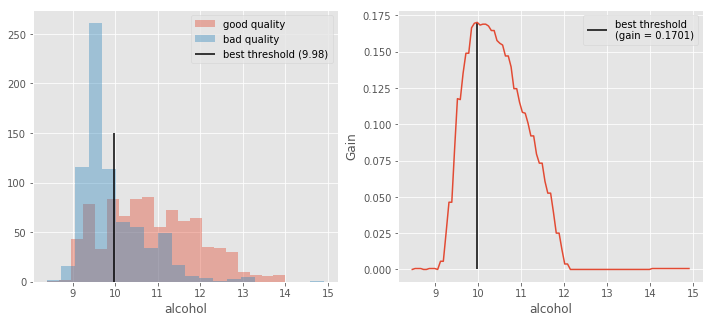

In [4]:
wine_demo()

# Some data

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import subprocess

* Load titanic [dataset](https://cloud.mail.ru/public/N1Tn/25zEKkqge)

In [6]:
df = pd.read_csv('titanic.csv')

In [7]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

* Analyse features and target variable
    * Type of features
    * Any missing values?
    * Class proportions

In [9]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

* Preprocess dataset
    * remove useless features
    * do something with missing values
    * do something with categorical features
    * split into train\test in proportion 80/20

In [10]:
def preproc_dataset(df_input):
    cols_2_drop = ['PassengerId', 'Ticket', 'Cabin', 'Name']
    df_input = df_input.drop(cols_2_drop, axis=1)
    
    df_input.loc[:, 'Age'] = df_input.Age.fillna(-999)
    df_input.loc[:, 'Sex'] = df_input.Sex.replace({'male': 0, 'female': 1})
    
    df_input = df_input.dropna()
    
    df_input = pd.get_dummies(df_input, columns=['Embarked'], prefix_sep='=')
    
    return df_input

In [11]:
df_input = df.pipe(preproc_dataset)

In [12]:
df_input.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked=C,Embarked=Q,Embarked=S
0,0,3,0,22.0,1,0,7.2500,0,0,1
1,1,1,1,38.0,1,0,71.2833,1,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,0,35.0,0,0,8.0500,0,0,1


In [13]:
label = 'Survived'
features = df_input.columns != label

In [14]:
features

array([False,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [15]:
X, y = df_input.loc[:, features].values, df_input.loc[:, label].values

In [16]:
X.shape

(889, 9)

In [17]:
y.shape

(889,)

 * Build any tree model and visualize it
 * Show feature importances

In [18]:
model = DecisionTreeClassifier()

model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [19]:
def plot_tree(tree, feature_names=None, class_names=['0', '1']):
    with open('tree.dot', 'w') as fout:
        export_graphviz(tree, out_file=fout, feature_names=feature_names, class_names=class_names)
    command = ["dot", "-Tpng", "tree.dot", "-o", "tree.png"]
    subprocess.check_call(command)
    plt.imshow(plt.imread('tree.png'))
    plt.axis("off")


In [20]:
feature_names = df_input.columns[features].values

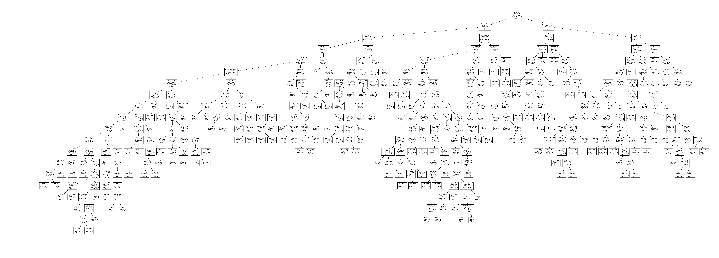

In [21]:
plot_tree(model, feature_names)

In [22]:
!head tree.dot

digraph Tree {
node [shape=box] ;
0 [label="Sex <= 0.5\ngini = 0.472\nsamples = 889\nvalue = [549, 340]\nclass = 0"] ;
1 [label="Fare <= 26.269\ngini = 0.306\nsamples = 577\nvalue = [468, 109]\nclass = 0"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Parch <= 0.5\ngini = 0.226\nsamples = 415\nvalue = [361, 54]\nclass = 0"] ;
1 -> 2 ;
3 [label="Age <= 32.5\ngini = 0.184\nsamples = 380\nvalue = [341, 39]\nclass = 0"] ;
2 -> 3 ;
4 [label="Age <= 30.75\ngini = 0.205\nsamples = 284\nvalue = [251, 33]\nclass = 0"] ;


In [25]:
imp = pd.Series(index=feature_names, data=model.feature_importances_)

In [26]:
imp.sort_values()

Embarked=C    0.005237
Embarked=Q    0.011657
Embarked=S    0.015204
SibSp         0.043675
Parch         0.049325
Pclass        0.090210
Age           0.215369
Fare          0.261941
Sex           0.307380
dtype: float64

* Using validation curve choose the best value for `max_depth` parameter

In [28]:
from sklearn.model_selection import cross_val_score
try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

In [29]:
model = DecisionTreeClassifier()

In [30]:
train_scores, valid_scores = validation_curve(model, X, y, 'max_depth', 
                                              range(1, 10), cv=5, 
                                              scoring='roc_auc', n_jobs=-1)

In [31]:
train_scores.shape

(9, 5)

In [32]:
valid_scores.shape

(9, 5)

In [39]:
mean_valid_scores = valid_scores.mean(axis=1)
std_valid_scores = valid_scores.std(axis=1)
mean_valid_scores

mean_train_scores = train_scores.mean(axis=1)
std_train_scores = train_scores.std(axis=1)
mean_train_scores

array([ 0.76593595,  0.83302732,  0.86384037,  0.88964101,  0.9125387 ,
        0.9335798 ,  0.95014907,  0.96410147,  0.97466237])

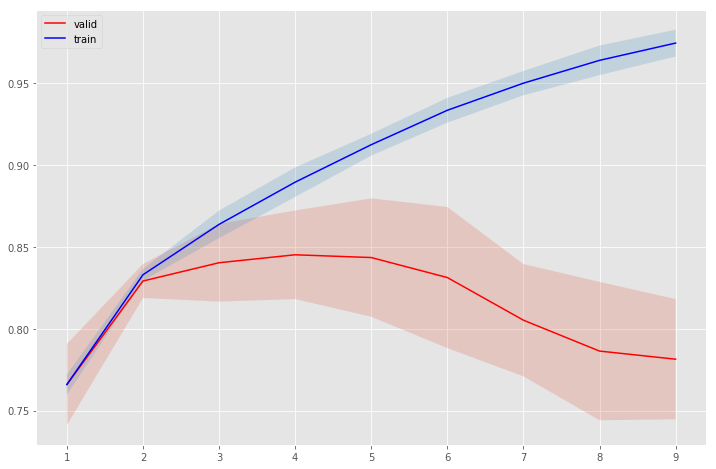

In [44]:
plt.plot(range(1,10), mean_valid_scores, label='valid', c='r')
plt.fill_between(range(1,10), mean_valid_scores-std_valid_scores, 
                 mean_valid_scores+std_valid_scores, alpha=0.2)
plt.plot(range(1,10), mean_train_scores, label='train', c='b')
plt.fill_between(range(1,10), mean_train_scores-std_train_scores, 
                 mean_train_scores+std_train_scores, alpha=0.2)

plt.legend()

* Now, consider other parameters of the model
* Run grid-search or randomized search of the optimal hyperparameter setting
* Check model quality on test set

In [45]:
from scipy.stats import randint as randint
from scipy.stats import uniform
try:
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
except ImportError:
    from sklearn.cross_validation import GridSearchCV
    from sklearn.cross_validation import RandomizedSearchCV


RND_SEED = 123

<center><img src='https://cdn-images-1.medium.com/max/800/1*ZTlQm_WRcrNqL-nLnx6GJA.png'></center>

In [48]:
param_grid = {
    'max_depth': randint(2, 8),
    'class_weight': [None, 'balanced'],
}

model = DecisionTreeClassifier()
search_cv = RandomizedSearchCV(model, param_grid, n_iter=10, scoring='roc_auc', n_jobs=-1, 
                               cv=5, random_state=123, verbose=5)
search_cv.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] max_depth=7, class_weight=None ..................................
[CV] max_depth=7, class_weight=None ..................................
[CV] max_depth=7, class_weight=None ..................................
[CV] max_depth=7, class_weight=None ..................................
[CV]  max_depth=7, class_weight=None, score=0.859090909091, total=   0.0s
[CV] max_depth=7, class_weight=None ..................................
[CV]  max_depth=7, class_weight=None, score=0.809692513369, total=   0.0s
[CV]  max_depth=7, class_weight=None, score=0.744050802139, total=   0.1s
[CV]  max_depth=7, class_weight=None, score=0.791778074866, total=   0.0s
[CV] max_depth=4, class_weight=None ..................................
[CV]  max_depth=7, class_weight=None, score=0.811049649217, total=   0.0s
[CV] max_depth=4, class_weight=None ..................................
[CV]  max_depth=4, class_weight=None, score=0.821457219251, total=   0.0

[Parallel(n_jobs=-1)]: Done  32 out of  50 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a206411d0>, 'class_weight': [None, 'balanced']},
          pre_dispatch='2*n_jobs', random_state=123, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=5)

In [49]:
search_cv.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [52]:
search_cv.best_params_

{'class_weight': 'balanced', 'max_depth': 4}

In [50]:
search_cv.grid_scores_

/Users/andrey.shestakov/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.80312, std: 0.03703, params: {'max_depth': 7, 'class_weight': None},
 mean: 0.84812, std: 0.02336, params: {'max_depth': 4, 'class_weight': None},
 mean: 0.84521, std: 0.02709, params: {'max_depth': 4, 'class_weight': None},
 mean: 0.84035, std: 0.02375, params: {'max_depth': 3, 'class_weight': None},
 mean: 0.85438, std: 0.02850, params: {'max_depth': 4, 'class_weight': 'balanced'},
 mean: 0.85401, std: 0.03157, params: {'max_depth': 3, 'class_weight': 'balanced'},
 mean: 0.84035, std: 0.02375, params: {'max_depth': 3, 'class_weight': None},
 mean: 0.84035, std: 0.02375, params: {'max_depth': 3, 'class_weight': None},
 mean: 0.84035, std: 0.02375, params: {'max_depth': 3, 'class_weight': None},
 mean: 0.82921, std: 0.01038, params: {'max_depth': 2, 'class_weight': None}]

In [51]:
search_cv.cv_results_

/Users/andrey.shestakov/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/andrey.shestakov/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/andrey.shestakov/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'mean_fit_time': array([ 0.00512638,  0.00378876,  0.00183353,  0.00170803,  0.00603638,
         0.00421557,  0.00154548,  0.00455704,  0.00328078,  0.00140386]),
 'mean_score_time': array([ 0.017343  ,  0.00895882,  0.00217667,  0.00214138,  0.00173302,
         0.00184884,  0.00166893,  0.0028708 ,  0.0020422 ,  0.00186715]),
 'mean_test_score': array([ 0.80312348,  0.84811855,  0.84521422,  0.84035483,  0.8543768 ,
         0.85400547,  0.84035483,  0.84035483,  0.84035483,  0.82920865]),
 'mean_train_score': array([ 0.95006755,  0.88964101,  0.88964101,  0.86384037,  0.88964352,
         0.86475308,  0.86384037,  0.86384037,  0.86384037,  0.83302732]),
 'param_class_weight': masked_array(data = [None None None None 'balanced' 'balanced' None None None None],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'param_max_depth': masked_array(data = [7 4 4 3 4 3 3 3 3 2],
              mask = [False False False False False F